# Predicting reddit comment karma | Web mining 

## Part II | Predicting using XGBoost  

### Ankita BHATTACHARYA
##### M2, Statistics & Econometrics, TSE

This second notebook contains the sequel to the first part of the Ask Reddit database anaylsis. Part I saw the feature generation that will be used to predict the comment karma on our test set. 

Predictions will be carried out using XGBoost

**Kernel : Python 3**

### Outline 
- Loading required libraries
- Importing the pickle files from Part I
   - Importing the text mining features (obtained using LDA)
   - Importing the network mining are other features 
- Quick look at our features 
- Further cleaning before prediction
- Split : train, test and validation sets
- Model : XGBoost implementation 
- Conclusion :  Feature importance
- Exportation for kaggle prediction

### Loading required libraries 

In [ ]:
!pip install xgboost

In [1]:
# Univeral
import pickle
import pandas as pd
import numpy as np
import math

# Normalization of variables
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Prediction algorithm
import xgboost as xgb

# Hyper-parameter tuning
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from parfit import bestFit

# Exportation
import csv

# Garbage collection
import gc

### Importing the pickle files from the last notebook, Part I. Exploratory Analysis

In [2]:
with open('dff.pkl', 'rb') as f:
    df = pickle.load(f)

Saving the index of the test comment_ids - later to be used for the Kaggle Prediction

In [3]:
ind = df[df['ups'].isnull()]['id']

####  Importing the text mining features

In [5]:
with open('lda_features.pkl', 'rb') as f:
    lda_features = pickle.load(f)


In [6]:
gc.collect()

47

#### Merging all features 
We need to merge the text mined and the network and time features. In order to do so, we first find the columns of lda_features that are not in the whole df and only concatenate with these colummns

In [9]:
inter = lda_features[lda_features.columns.difference(df.columns)]

In [10]:
df = pd.concat([df, inter], axis=1)

### Quick look : Features

In [11]:
numerical_features = ['num_words', 'words_caps', 'num_exclamation_marks', 'num_question_marks', 
                      'num_punctuation', 'num_subject', 'urlcount', 'sub_reddits',
                      'time_between_comments', 'time_diff_parent', 'rep_first',
                      'thread_pop','comment_depth','count_nb',
                      'degree_centrality', 'betweenness_centrality', 
                      'eigenvector_centrality', 
                      'parent_score', 'nb_com_author','lexicalDiversity', 'is_referencing']

other_time_related = ['hour_of_comment', 'day_of_comment']
lda_features_names = list(inter)
total_features = []
total_features.extend(numerical_features)
total_features.extend(other_time_related)
total_features.extend(lda_features_names)


print("Total  features :", total_features)
print("Total number of features : ", len(total_features))

Total  features : ['num_words', 'words_caps', 'num_exclamation_marks', 'num_question_marks', 'num_punctuation', 'num_subject', 'urlcount', 'sub_reddits', 'time_between_comments', 'time_diff_parent', 'rep_first', 'thread_pop', 'comment_depth', 'count_nb', 'degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'parent_score', 'nb_com_author', 'lexicalDiversity', 'is_referencing', 'hour_of_comment', 'day_of_comment', 'delet', 'dont', 'fuck', 'good', 'know', 'like', 'look', 'make', 'need', 'peopl', 'pleas', 'post', 'question', 'realli', 'thing', 'think', 'time', 'want', 'work', 'year']
Total number of features :  43


### Further cleaning before the prediction

Let us look at how our features are distributed. We see that variables like num_words or num_punctuations, or number of punctuations are heavily skewed. 

In [12]:
df[numerical_features].describe().apply(lambda i: i.apply(lambda x: format(x, 'g')))

,num_words,words_caps,num_exclamation_marks,num_question_marks,num_punctuation,num_subject,urlcount,sub_reddits,time_between_comments,time_diff_parent,...,thread_pop,comment_depth,count_nb,degree_centrality,betweenness_centrality,eigenvector_centrality,parent_score,nb_com_author,lexicalDiversity,is_referencing
count,4.23496e+06,4.23496e+06,4.2349e+06,4.2349e+06,4.2349e+06,4.2349e+06,4.23496e+06,4.23496e+06,4.23496e+06,2.51019e+06,...,4.23496e+06,4.23496e+06,4.23496e+06,4.23496e+06,4.23496e+06,4.23496e+06,4.23496e+06,4.23496e+06,4.23496e+06,4.23496e+06
mean,25.7532,4.41557,0.12605,0.192282,143.334,1.14351,0.0428056,0.0477204,27906.6,16701,...,4909.74,2.88944,1.59273,0.0146589,0.0363002,0.0737727,216.64,23442.2,0.396484,0.0167359
std,47.0631,17.5429,0.68321,0.800421,264.107,2.54478,0.310381,0.475616,67661.5,42920,...,7260.5,7.74423,3.07449,0.0511761,0.128261,0.260848,733.785,81453.5,0.252035,0.12828
min,0,0,0,0,1,0,0,0,0,0,...,1,1,1,0,0,0,-333,1,0,0
25%,4,1,0,0,25,0,0,0,2333,1077,...,39,1,1,1.45641e-05,1.98022e-07,6.47385e-08,10,8,0.184466,0
50%,12,2,0,0,65,0,0,0,18760,7388,...,1487,2,1,6.79659e-05,8.57177e-06,4.54704e-05,10,33,0.347826,0
75%,28,4,0,0,154,1,0,0,37462,22224,...,6845,3,2,0.000300992,6.53684e-05,0.000185995,10,149,0.596774,0
max,3656,10000,328,680,10000,1215,99,65,2.67749e+06,2.55609e+06,...,35812,416,885,0.196113,0.491092,0.998706,6761,312007,1,1


Let us normlize the variables before we proceed in order not to skew the predictions After a brief visual inspection we take features having s.d. > 4 to be scaled.

In [13]:
# Selecting variables to normalize : 9
to_normalize = [i for i in numerical_features if df[i].std() > 4]
to_normalize

['num_words',
 'words_caps',
 'num_punctuation',
 'time_between_comments',
 'time_diff_parent',
 'thread_pop',
 'comment_depth',
 'parent_score',
 'nb_com_author']

In [14]:
# Dropping columns not useful for prediction
# These columns are strings and will not be able to help in prediction
to_drop = ["created_utc", "subreddit_id","subreddit","id", "link_id", "name", "author", "body", "parent_id"]
df.drop(columns=to_drop, inplace=True)

In [15]:
# We divide the df into variables to normalize and those not to. 
# Creating the database containing vars to be normalized
df_to_normalize = df[to_normalize]

# Storing variables not to normalize apart
rest_features = [f for f in total_features if f not in to_normalize]
rest_features.append('ups')
not_to_normalize = df[rest_features]

In [16]:
# Standard normalization - subtract from mean and divide by standard deviation 
normalizer = StandardScaler()
normed_np_array = normalizer.fit_transform(df_to_normalize.values)
df_normalized = pd.DataFrame(normed_np_array, index=df_to_normalize.index, columns=df_to_normalize.columns)

In [17]:
# Combining all the normalized and other features into one single dataframe
df_normalized = pd.concat([df_normalized, not_to_normalize], axis=1)

In [18]:
# Remove datasets we will not use further from memory memory
del lda_features

### Splitting into train, validation and test sets

In [19]:
test_df = df_normalized[df_normalized['ups'].isnull()]
test_df.head()

,num_words,words_caps,num_punctuation,time_between_comments,time_diff_parent,thread_pop,comment_depth,parent_score,nb_com_author,num_exclamation_marks,...,post,question,realli,thing,think,time,want,work,year,ups
3218500,0.982655,1.230381,2.569661,-0.411513,NaN,-0.675951,-0.243981,-0.281609,-0.284693,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3218501,-0.525959,-0.194698,-0.523782,-0.389403,NaN,-0.675538,-0.243981,-0.281609,-0.285896,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3218502,-0.334726,-0.137695,-0.364755,-0.315447,-0.267777,-0.663142,0.014276,-0.259804,-0.286817,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3218503,-0.122245,-0.080692,-0.092139,-0.406340,NaN,-0.675538,-0.243981,-0.281609,-0.287553,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3218504,-0.355974,-0.137695,-0.349610,0.167782,0.488607,0.841575,-0.114853,5.654737,-0.287320,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train_df = df_normalized[df_normalized['ups'].notnull()]
train_df.head()

,num_words,words_caps,num_punctuation,time_between_comments,time_diff_parent,thread_pop,comment_depth,parent_score,nb_com_author,num_exclamation_marks,...,post,question,realli,thing,think,time,want,work,year,ups
0,-0.100997,0.033314,-0.092139,-0.412444,NaN,-0.292506,-0.243981,-0.281609,-0.287136,0.0,...,0.05,0.05,2.684066,0.065346,0.294007,13.695853,0.079638,0.05,0.05,3.0
1,-0.334726,-0.137695,-0.360969,-0.412444,NaN,1.024621,-0.243981,-0.281609,-0.287737,0.0,...,0.05,0.05,0.110765,0.050000,0.099479,0.070763,215594.422390,0.05,0.05,3.0
2,-0.525959,-0.023689,-0.527568,-0.412444,NaN,0.321914,-0.243981,-0.281609,-0.287099,0.0,...,0.05,0.05,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.05,5.0
3,-0.249734,-0.137695,-0.338251,-0.412444,NaN,-0.474312,-0.243981,-0.281609,-0.287737,0.0,...,0.05,0.05,0.051699,0.050000,280496.272504,0.050000,0.050000,0.05,0.05,1.0
4,0.366461,-0.080692,0.369795,-0.412429,NaN,-0.292506,-0.243981,-0.281609,-0.287774,0.0,...,0.05,0.05,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.05,101.0


In [21]:
# Remove datasets we will not use further from memory memory

del df_normalized
del df

Now taking apart the **ups** variable

In [23]:
train_y = train_df.ups
train_df= train_df.drop('ups', axis=1)

In [24]:
test_df = test_df.drop('ups', axis=1)

Splitting the train set into into train (80%) and validation (20%) sets. This will be then used to check for overfitting in the section to follow 

In [25]:
X_train, X_validation, y_train, y_validation = train_test_split(train_df, train_y, test_size=0.2, random_state=123)

In [103]:
del train_df

## Model : XG Boost

In [26]:
# Let us first run a naive model without selecting any params like learning rate, n_estimators or the depth we will later run a grid sea
xgb_reg = xgb.XGBRegressor(n_jobs=-1, random_state=1139, verbosity=2, colsample_bytree=1, eta = 0.1, max_depth = 6)
xgb_reg.fit(X_train.values, y_train.values)

[10:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[10:53:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[10:53:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[10:53:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[10:53:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[10:53:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nod

[10:56:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[10:56:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[10:56:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[10:56:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[10:56:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[10:56:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0

[10:58:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[10:58:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[10:58:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[10:58:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1139, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

### Check for overfitting

We check for overfitting using the mean absolute error compared to the validation set

In [27]:
predicted_train = xgb_reg.predict(X_train.values)
predicted_validation = xgb_reg.predict(X_validation.values)
train_MAE = round(mean_absolute_error(y_train, predicted_train), 2)
validation_MAE = round(mean_absolute_error(y_validation, predicted_validation), 2)
print("Training MAE:", train_MAE)
print("Validation MAE:", validation_MAE)
    

Training MAE: 8.4
Validation MAE: 8.82


The training MAE is less than the validation MAE. So how to deal with overfitting ? 

In [29]:
params = {
    "n_estimators": np.array([45, 60, 75]),
    "max_depth": np.array([5,6,9])
}

xgb_1 = xgb.XGBRegressor(
    eta = 0.1,
    njobs = -1,
    seed=1139)

In [30]:
gc.collect()

40

The first method I tried was using GridSearchCV (inspired by: https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost) but this would take too long and my computer would crash. After having searched on the internet for other ways to gridsearch I found the parfit library which has a bestFit function to tune the model by brute search. Here the metric chosen was the mean absolute error.

In [ ]:
# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# grid = GridSearchCV(estimator=xgb_1, param_grid=params, scoring='roc_auc',  cv=skf.split(X_train, y_train), verbose=3 )
# grid.fit(X_train, y_train)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed: 22.4min remaining: 78.4min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 24.9min remaining: 49.7min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 26.1min remaining: 32.7min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 26.6min remaining: 21.3min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 26.7min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 27.5min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 32.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    4.9s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.6s finished


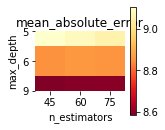

In [70]:
best_model, best_score, all_models, all_scores = bestFit(
    model = xgb_1,
    paramGrid = ParameterGrid(params), 
    X_train = X_train,
    y_train = y_train,
    X_val = X_validation,
    y_val = y_validation,
    metric = mean_absolute_error,
    scoreLabel = "mean_absolute_error")

In [71]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=45, n_jobs=8, njobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1139, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=1139, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

As seen from the graphic above we tried using the best model of 45 estimators and 9 depth levels. The score was 9.59 on Kaggle, but the best performance on Kaggle - **9.38**, was rendered by another combination of the parameters : **60 estimators and a depth of 6  with a learning rate of 0.2**.

In [32]:
best_n_estimators = 60
best_max_depth = 6

In [33]:
xgb_reg_best = xgb.XGBRegressor(n_estimators=best_n_estimators,
                                eta=0.2,
                                max_depth=best_max_depth,
                                subsample=0.9,
                                colsample_bytree=0.8,
                                gamma=0,
                                n_jobs=-1,
                                verbosity=2,
                                seed=1139)

xgb_reg_best.fit(X_train.values, y_train.values)

[12:49:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[12:49:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[12:50:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[12:50:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[12:50:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[12:50:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nod

[12:52:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[12:52:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[12:52:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[12:52:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[12:52:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[12:52:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1139, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=1139, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=2)

###  Conclusion : Feature Importance
We now want to see which feature contributed the most to the model. 
- We see that the neighbour count has the highest score followed by the variable capturing replies to the first comment 
- Structural and time based features are a lot more important than text features

In [36]:
feature_weights = pd.DataFrame(xgb_reg_best.feature_importances_, columns=['weight'], index=X_train.columns)
feature_weights.sort_values('weight', inplace=True)
feature_weights.tail(5)

,weight
degree_centrality,0.033247
time_diff_parent,0.056725
parent_score,0.058122
rep_first,0.138812
count_nb,0.423887


In [37]:
# Kaggle prediction
kaggle_prediction = np.round(xgb_reg_best.predict(test_df.values))
predict = pd.DataFrame(kaggle_prediction, columns = ["predicted"], index = ind )
predict.to_csv("prediction.csv", index = True)

In [38]:
import gc
gc.collect()

155

##  You have reached the end of this notebook